In [5]:
import sys
sys.path.append("../scripts/")
from gridmap import *
from sarsa import *
import math
import copy
import random
from matplotlib.animation import PillowWriter    #アニメーション保存用
#%matplotlib notebook

In [10]:
class NStepSarsa(Sarsa):
    def __init__(
        self, grid_map_world, drawPI=False, drawQ=False, drawPath=False, drawQPath=False, nstep=10,
        epsilon=1.0, gamma=1.0, alpha=0.5
    ):
        super().__init__(
            grid_map_world, drawPI=drawPI, drawQ=drawQ, drawPath=drawPath, drawQPath=drawQPath,
            epsilon=epsilon, gamma=gamma, alpha=alpha
        )
        self.s_trace = []
        self.a_trace = []
        self.r_trace = []
        self.nstep = nstep
        
    def draw(self, ax, elems):
        traversed_grids = self.episode()
        if(self.drawPIflag):
            self.drawPI(ax, elems)
        if(self.drawQflag):
            self.drawQ(ax, elems)
        if(self.drawQPathflag):
            self.drawQPath(ax, elems)
        if(self.drawPathflag):
            self.drawTraversedPath(traversed_grids, ax, elems)
            
    #1エピソードを実行
    def episode(self):
        traversed_grids = []
        self.s_trace = []
        self.a_trace = []
        self.r_trace = []
        s, s_ = None, copy.copy(self.world.start_index)
        a, a_ = None, None
        for i in range(200):
            if(self.isOutOfBounds(s_) or self.isObstacle(s_) or self.isGoal(s_)):
                self.updateQ(s_, a_, self.nstep)
                break
            else:
                a_ = self.policy(s_)    #方策
                self.updateQ(s_, a_, self.nstep)
                s = copy.copy(s_)
                a = copy.copy(a_)
                s_ = self.moveRobot(s_, a_)
                r = self.r(s, a, s_)
                self.s_trace.append(s)
                self.a_trace.append(a)
                self.r_trace.append(r)
                traversed_grids.append(copy.copy(s_))
        return traversed_grids
            
    #行動価値関数更新
    def updateQ(self, s_, a_, n):
        if n > len(self.s_trace) or n == 0:
            if(self.isOutOfBounds(s_) or self.isObstacle(s_)):
                s, a = self.s_trace[-2], self.a_trace[-2]
                self.q_map[s[0]][s[1]][a] -= 100
            return
        if(self.isOutOfBounds(s_) or self.isObstacle(s_)):
            q_ = -100
        elif(self.isGoal(s_)):
            q_ = 0.0
        else:
            q_ = self.Q(s_, a_)
        s, a, r = self.s_trace[-n], self.a_trace[-n], sum(self.r_trace[-n:])
        q = self.Q(s, a)
        self.q_map[s[0]][s[1]][a] = (1- self.alpha) * q + self.alpha * (r + self.gamma * q_)  
        if(self.isOutOfBounds(s_) or self.isObstacle(s_) or self.isGoal(s_)):
            self.updateQ(s_, a_, n-1)

<IPython.core.display.Javascript object>


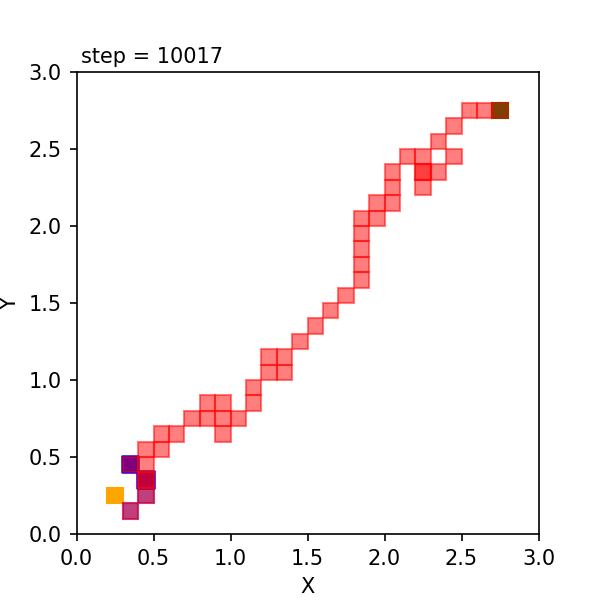

In [11]:
if __name__ == "__main__":
    time_span =  2000
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "../csvmap/map1.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(NStepSarsa(world, drawQ=False, drawPath=True, drawQPath=True, nstep=2, epsilon=0.9))
    
    world.draw()
    #world.ani.save('sarsa_map2_q.gif', writer='pillow', fps=60)    #アニメーション保存